In [4]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np

## Exercise 1 (AA_test p-value)

In [5]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

q = """
SELECT distinct user_id
FROM {db}.feed_actions 
WHERE toDate(time) >= '2021-11-15' and toDate(time) <= '2021-11-21' 
"""

In [6]:
q_ctr = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220520.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-04-17' and toDate(time)<='2022-04-23' 
'''

In [7]:
df_ctr = pandahouse.read_clickhouse(query=q_ctr, connection=connection)

In [8]:
# параметры распределений групп 2 и 3 очень близкие.
df_ctr.groupby('exp_group')['ctr'].describe()[2:4]

,count,mean,std,min,25%,50%,75%,max
exp_group,,,,,,,,
2,8480.0,0.218246,0.080643,0.0,0.164451,0.205882,0.260870,0.714286
3,8569.0,0.219161,0.080932,0.0,0.166667,0.206612,0.261538,0.714286


In [11]:
sns.set(rc={'figure.figsize':(10,5)})

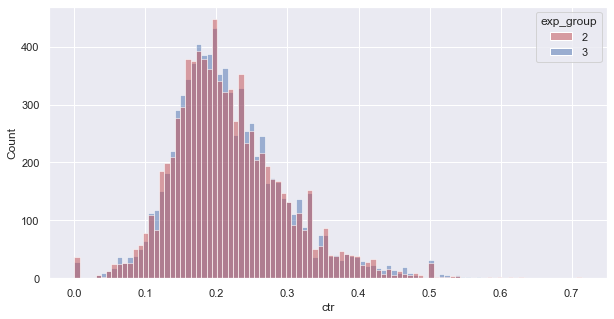

In [12]:
# Проверяем распределение. Выбросы на 0,0 и 0,5. Лучше сгладить.
# Сами распределние довольно похожи. 
sns.histplot(data = df_ctr[(df_ctr['exp_group']==2) | (df_ctr['exp_group']==3)], x='ctr', palette=['r','b'], hue='exp_group');

In [13]:
# количество of ctr = 0 or 1
df_ctr_2 = df_ctr[df_ctr['exp_group']==2]
df_ctr_3 = df_ctr[df_ctr['exp_group']==3]
(df_ctr_2.ctr==0).sum(), (df_ctr_2.ctr==1).sum(), (df_ctr_3.ctr==0).sum(), (df_ctr_3.ctr==1).sum()

(36, 0, 29, 0)

In [15]:
# делаем итерации выборок из множеств групп 2 и 3 и считаем p-value на каждую выборку
iter = 10**5 # сделаем на порядок побольше чем указано в задании
sample_size = 500

pvalues=[]
for i in range(0, iter):
    _, pvalue = stats.ttest_ind(df_ctr_2['ctr'].sample(sample_size, replace=True),
                                df_ctr_3['ctr'].sample(sample_size, replace=True),
                                equal_var=False)
    pvalues.append(pvalue)

<AxesSubplot:ylabel='Count'>

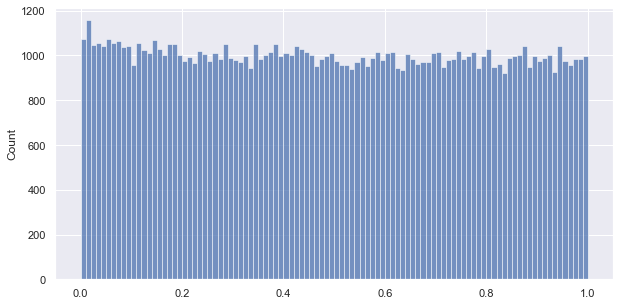

In [16]:
# распредеоение довольно равномерное, но есть всплеск у нуля.
sns.histplot(pvalues, bins=100)

In [17]:
# считаем долю p-values, которые меньше или равны 0.5. 
(pd.Series(pvalues)<=0.05).sum()/(pd.Series(pvalues)).count()

0.05378

**Вывод 1:** 
доля p-values, равных или меньше 0,5, составляет чуть больше 5%. Само распределение p-values равномерное. Хотя некоторый выступ в районе 0 все-так есть. 

Из чего можно сделать вывод, что выборки довольно одинаковые. Система сплитования в целом работает.

### smoothed ctr

In [18]:
def smoothed_ctr(like, view, general_ctr, alpha):
    return (like + alpha*general_ctr) / (view + alpha)

In [19]:
# считаем глобальные ctr
global_ctr2 = df_ctr_2.likes.sum() / df_ctr_2.views.sum()
global_ctr3 = df_ctr_3.likes.sum() / df_ctr_3.views.sum()

In [20]:
# сглаженные ctr
df_ctr_2['smoothed_ctr'] = df_ctr_2.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr2, 5), axis=1)

df_ctr_3['smoothed_ctr'] = df_ctr_3.apply(
    lambda x: smoothed_ctr(x['likes'], x['views'], global_ctr3, 5), axis=1)


/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46090/120937281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_2['smoothed_ctr'] = df_ctr_2.apply(
/var/folders/00/jtb7c8xn51902fgjqt4qh5h80000gp/T/ipykernel_46090/120937281.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ctr_3['smoothed_ctr'] = df_ctr_3.apply(


<AxesSubplot:xlabel='smoothed_ctr', ylabel='Count'>

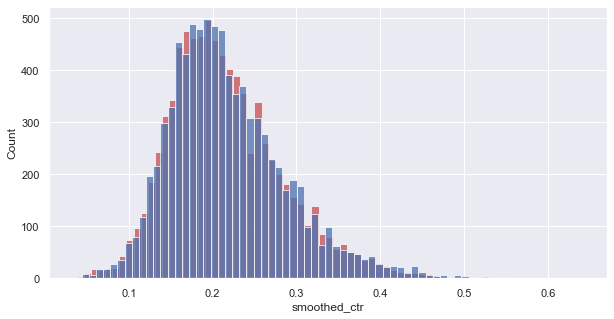

In [21]:
sns.histplot(df_ctr_2.smoothed_ctr, color='r')
sns.histplot(df_ctr_3.smoothed_ctr, color='b')

In [22]:
# делаем итерации выборок из множеств групп 2 и 3 и считаем p-value на каждую выборку
iter = 10**5 # сделаем на порядок побольше чем указано в задании
sample_size = 500

pvalues=[]
for i in range(0, iter):
    _, pvalue = stats.ttest_ind(df_ctr_2.smoothed_ctr.sample(sample_size, replace=True),
                                df_ctr_3.smoothed_ctr.sample(sample_size, replace=True),
                                equal_var=False)
    pvalues.append(pvalue)

<AxesSubplot:ylabel='Count'>

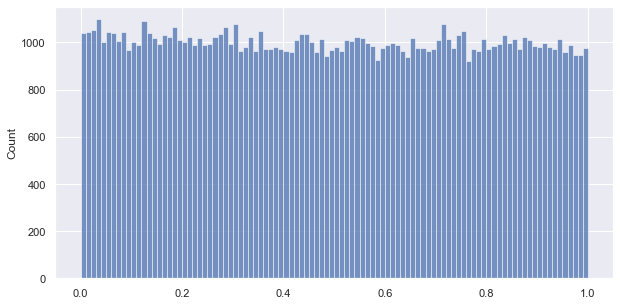

In [23]:
# распредеоение кажется стало более равномерным (нет такого всплекска у нуля)
sns.histplot(pvalues, bins=100)

In [24]:
# считаем долю p-values, которые меньше или равны 0.5. 
share_05pvalue = (pd.Series(pvalues)<=0.05).sum()/(pd.Series(pvalues)).count()
print(f'Доля p-values меньше или равно 0,05 = {share_05pvalue}')

Доля p-values меньше или равно 0,05 = 0.05234


**Вывод 2:** 
после сглаживания доля p-values <=0.05 стала ближе к 5%. То есть выборки стали вроде как более одинаковые. 

Но помним, что теоретически не доказано , что сглаживание можно использовать.